## kNN classifiers

### Imports and global variables

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

import imp
plotter = imp.load_source('plotter', '/Users/katbishop/Desktop/DSI-SF2-bishopkd/utils/plotting/knn_plotter.py')
from sklearn.metrics import roc_curve, auc
from plotter import KNNBoundaryPlotter
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

plt.style.use('fivethirtyeight')
%matplotlib inline

path = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/projects/capstone/data/'

#### Load the data

In [121]:
# load training data
df = pd.read_csv(path + 'df.csv')
del df['Unnamed: 0']
#del df['Unnamed: 0.1']

# load held-out testing data
df_test = pd.read_csv(path + 'df_test.csv')
del df_test['Unnamed: 0']

df_all = pd.concat([df,df_test], axis=0).reset_index()
del df_all['index']

print df.shape
print df_test.shape
print df_all.shape
df_all.head(2)

(780, 63)
(141, 63)
(921, 63)


,adj,adj_compare,adj_sup,adv,adv_compare,adv_part,adv_sup,avg_sent_len,avg_word_len,best_seller,...,verb_count,verb_ger,verb_past,verb_pp,verb_sing_pres,wh_adv,wh_determ,wh_poss,wh_pronoun,word_count
0,0.065870,0.001992,0.003091,0.063397,0.001099,0.006937,0.000206,13,4,1,...,2599.0,0.023079,0.066282,0.021087,0.025483,0.006319,0.003915,0.0,0.003846,14559
1,0.064633,0.003045,0.001282,0.064847,0.001709,0.008333,0.000374,18,4,1,...,3359.0,0.022221,0.070135,0.024838,0.019497,0.005769,0.004754,0.0,0.006303,18721


In [122]:
# subset the data
sf = df_all[df_all['sci_fi']==1]
rm = df_all[df_all['sci_fi']==0]
print sf.shape
print rm.shape

(470, 63)
(451, 63)


#### Science-fiction

In [123]:
y_sf = sf['best_seller'].values
#X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane']].values
X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']].values
print y_sf.shape, X_sf.shape

X_sf, X_sf_test, y_sf, y_sf_test = train_test_split(X_sf, y_sf, test_size=0.3)

print X_sf.shape, y_sf.shape
print X_sf_test.shape, y_sf_test.shape

(470,) (470, 54)
(329, 54) (329,)
(141, 54) (141,)


In [124]:
def accuracy_crossvalidator(X, y, knn, cv_indices):
    scores = []
    for train_i, test_i in cv_indices:
        
        X_train = X[train_i, :]
        X_test = X[test_i, :]
        y_train = y[train_i]
        y_test = y[test_i]

        knn.fit(X_train, y_train)
        acc = knn.score(X_test, y_test)
        scores.append(acc)
        
        print('Fold accuracy:', acc)    
    print('Mean CV accuracy:', np.mean(scores))

In [125]:
cv = StratifiedKFold(y_sf, n_folds=10)
knn_sf = KNeighborsClassifier(n_neighbors=3, weights='distance')
accuracy_crossvalidator(X_sf, y_sf, knn_sf, cv)

('Fold accuracy:', 0.88235294117647056)
('Fold accuracy:', 0.8529411764705882)
('Fold accuracy:', 0.88235294117647056)
('Fold accuracy:', 0.72727272727272729)
('Fold accuracy:', 0.72727272727272729)
('Fold accuracy:', 0.72727272727272729)
('Fold accuracy:', 0.875)
('Fold accuracy:', 0.84375)
('Fold accuracy:', 0.71875)
('Fold accuracy:', 0.84375)
('Mean CV accuracy:', 0.80807152406417104)


In [126]:
search_parameters = {
    'n_neighbors': range(1,12), 
    'weights':      ['uniform','distance']
}

knn = KNeighborsClassifier() 
knn_gs = GridSearchCV(knn, search_parameters, cv=10, verbose=1)

knn_sf = knn_gs.fit(X_sf, y_sf)
knn_proba_sf = knn_sf.predict_proba(X_sf_test)

print knn_sf.best_params_
best_knn_sf = knn_sf.best_estimator_
print best_knn_sf
accuracy_crossvalidator(X_sf, y_sf, best_knn_sf, cv)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s


{'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
('Fold accuracy:', 0.94117647058823528)
('Fold accuracy:', 0.8529411764705882)
('Fold accuracy:', 0.88235294117647056)
('Fold accuracy:', 0.90909090909090906)
('Fold accuracy:', 0.72727272727272729)
('Fold accuracy:', 0.81818181818181823)
('Fold accuracy:', 0.90625)
('Fold accuracy:', 0.84375)
('Fold accuracy:', 0.84375)
('Fold accuracy:', 0.90625)
('Mean CV accuracy:', 0.86310160427807481)


[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.8s finished


#### Romance

In [136]:
print "score on testing data", best_knn_sf.score(X_sf_test, y_sf_test)

score on testing data 0.879432624113


In [127]:
y_rm = rm['best_seller'].values
X_rm = rm[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']].values

print  X_rm.shape,y_rm.shape

X_rm, X_rm_test, y_rm, y_rm_test = train_test_split(X_rm, y_rm, test_size=0.3)

print X_rm.shape, y_rm.shape
print X_rm_test.shape, y_rm_test.shape

(451, 54) (451,)
(315, 54) (315,)
(136, 54) (136,)


In [128]:
cv_rm = StratifiedKFold(y_rm, n_folds=10)
knn_rm = KNeighborsClassifier(n_neighbors=3, weights='uniform')
accuracy_crossvalidator(X_rm, y_rm, knn_rm, cv_rm)

('Fold accuracy:', 0.78125)
('Fold accuracy:', 0.8125)
('Fold accuracy:', 0.78125)
('Fold accuracy:', 0.84375)
('Fold accuracy:', 0.78125)
('Fold accuracy:', 0.9375)
('Fold accuracy:', 0.84375)
('Fold accuracy:', 0.77419354838709675)
('Fold accuracy:', 0.80000000000000004)
('Fold accuracy:', 0.8666666666666667)
('Mean CV accuracy:', 0.82221102150537639)


In [138]:
search_parameters = {
    'n_neighbors': range(1,12), 
    'weights':      ['uniform','distance']
}

knn_rm = KNeighborsClassifier() 
knn_rm_gs = GridSearchCV(knn_rm, search_parameters, cv=10, verbose=1)

knn_rm = knn_rm_gs.fit(X_rm, y_rm)
knn_proba_rm = knn_rm.predict_proba(X_rm_test)

print knn_rm_gs.best_params_
best_knn_rm = knn_rm_gs.best_estimator_
print best_knn_rm
accuracy_crossvalidator(X_rm, y_rm, best_knn_rm, cv_rm)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s


{'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
('Fold accuracy:', 0.875)
('Fold accuracy:', 0.8125)
('Fold accuracy:', 0.84375)
('Fold accuracy:', 0.84375)
('Fold accuracy:', 0.9375)
('Fold accuracy:', 0.9375)
('Fold accuracy:', 0.9375)
('Fold accuracy:', 0.87096774193548387)
('Fold accuracy:', 0.8666666666666667)
('Fold accuracy:', 0.93333333333333335)
('Mean CV accuracy:', 0.88584677419354851)


[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.8s finished


In [139]:
print "score on testing data", best_knn_rm.score(X_rm_test, y_rm_test)

score on testing data 0.823529411765


#### All together now, just for fun

In [130]:
y = df['best_seller'].values
X = df[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']].values

print y.shape, X.shape

X, X_test, y, y_test = train_test_split(X, y, test_size=0.3)

print X.shape, y.shape
print X_test.shape, y_test.shape


(780,) (780, 54)
(546, 54) (546,)
(234, 54) (234,)


In [140]:
cv_all = StratifiedKFold(y, n_folds=10)
search_parameters = {
    'n_neighbors': range(1,12), 
    'weights':      ['uniform','distance']
}

knn = KNeighborsClassifier() 
knn_gs = GridSearchCV(knn, search_parameters, cv=10, verbose=1)

knn_all = knn_gs.fit(X, y)
knn_proba_all = knn_all.predict_proba(X_test)
print knn_gs.best_params_
best_knn = knn_gs.best_estimator_
print best_knn
accuracy_crossvalidator(X, y, best_knn, cv_all)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s


{'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
('Fold accuracy:', 0.89090909090909087)
('Fold accuracy:', 0.92727272727272725)
('Fold accuracy:', 0.87272727272727268)
('Fold accuracy:', 0.94545454545454544)
('Fold accuracy:', 0.81818181818181823)
('Fold accuracy:', 0.8545454545454545)
('Fold accuracy:', 0.88888888888888884)
('Fold accuracy:', 0.83333333333333337)
('Fold accuracy:', 0.83333333333333337)
('Fold accuracy:', 0.92592592592592593)
('Mean CV accuracy:', 0.87905723905723909)


[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    1.0s finished


In [141]:
print "score on testing data", best_knn.score(X_test, y_test)

score on testing data 0.867521367521


In [131]:
def plot_roc_curve(target=False, predict_proba=False, title='Your prediction'):

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    FPR[1], TPR[1], _ = roc_curve(target,predict_proba)
    ROC_AUC[1] = auc(FPR[1], TPR[1])
    acc_ = np.abs(0.5 - np.mean(target)) + 0.5

    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4, color='darkred')
    #plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(' %s' % title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

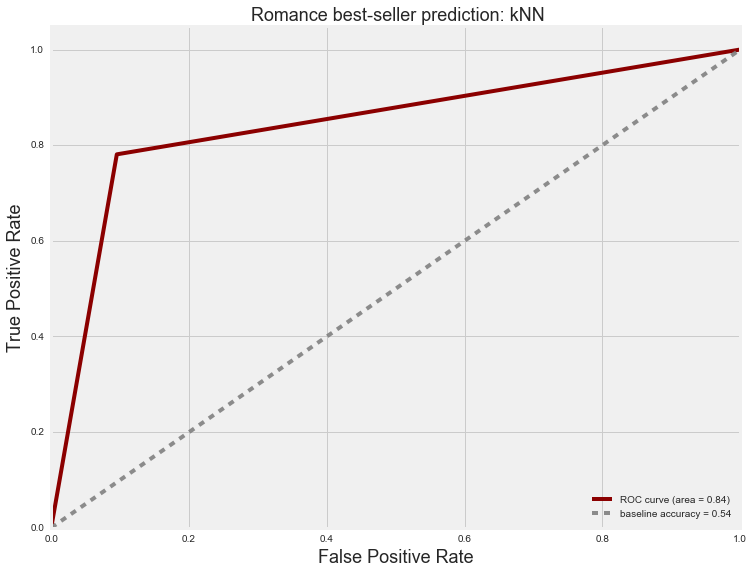

In [133]:
plot_roc_curve(target=y_rm_test, predict_proba=knn_proba_rm[:,1], title='Romance best-seller prediction: kNN')

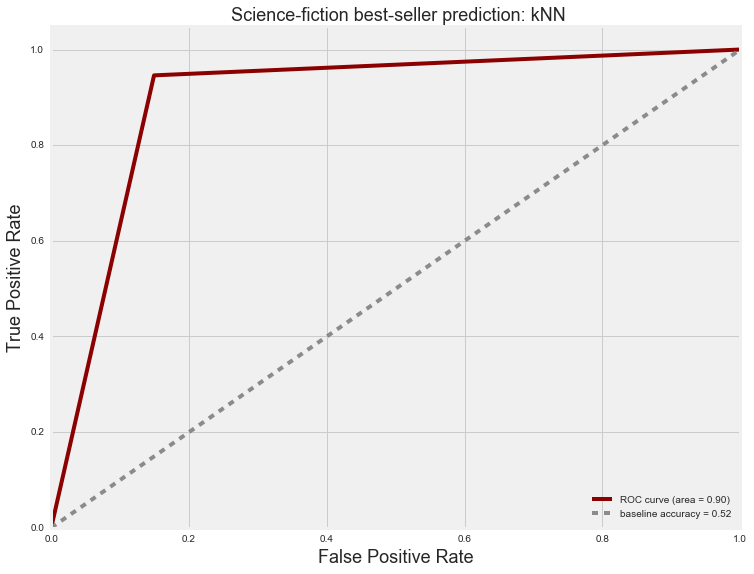

In [135]:
plot_roc_curve(target=y_sf_test, predict_proba=knn_proba_sf[:,1], title='Science-fiction best-seller prediction: kNN')